<a href="https://colab.research.google.com/github/nvb5140/CS583-Deep-Learning-NB/blob/main/HW/HW2/Programming2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment: Build a CNN for image recognition.

### Name: Nick Benelli


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accuracy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.


4. Upload the .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
from keras.datasets import cifar10
import numpy
import pandas as pd

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Training (train) and Testings (test) Sets:')
print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

170508288/170498071 [==============================] - 11s 0us/step
Training (train) and Testings (test) Sets:
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [3]:
def to_one_hot(y, num_class=10):
    '''
    Covnert integer classes in a one-hot encoding vector. i.e 3 = [0,0,0,1,0]

    Parameters
    ----------
    y : numpy.ndarray
        label vector.
    num_class : int, optional
        number of classes in multi-class classifcation. The default is 10.

    Returns
    -------
    y_one_hot : numpy.ndarray
        one-hot encoding matrix of y.

    '''
    y_one_hot = numpy.zeros((len(y), num_class))
    for i, y_i in enumerate(y):
        y_one_hot[i, y_i] = 1
    return y_one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [4]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Train (tr) and Validation (val) Sets:')
print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Train (tr) and Validation (val) Sets:
Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential

def create_model():
  # Model
  model = Sequential()
  # set 1
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu')) 
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))

  # set 2
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))

  # set 3
  model.add(Dropout(0.3)) 
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))

  # (final set)
  model.add(Flatten())
  model.add(Dropout(0.4)) # before first dense layer
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(10, activation='softmax'))  # multi-class classifcation

  return model

# model summary
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0

In [6]:
#from keras import optimizers
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Hyperparams
batch_size = 32
epochs = 40

# Data Augmentation 
rescale = 1./255
rotation_range = 10
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.2
horizontal_flip=True

# Model Parameters
learning_rate = 1E-3 # to be tuned!
loss='categorical_crossentropy'
metrics = ['acc']

# Data Augmenation
train_datagen = ImageDataGenerator(
    rescale = rescale,
    rotation_range = rotation_range,
    width_shift_range = width_shift_range,
    height_shift_range = height_shift_range,
    shear_range = shear_range,
    zoom_range = zoom_range,
    horizontal_flip = horizontal_flip)

val_datagen = ImageDataGenerator(rescale= rescale)

train_datagen.fit(x_tr)
train_generator = train_datagen.flow(x_tr, y_tr, batch_size=batch_size)
test_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

# Compile Model
model.compile(
    loss=loss,
    optimizer= optimizers.RMSprop(
        learning_rate= learning_rate),
    metrics = metrics
)


In [7]:
# epoch breakdown
model_wgt_path = '/content/drive/My Drive/Colab Notebooks/checkpoints'


epochs_to_run = 20  # number of epochs per round


In [8]:
# Accuracy and Validation Accuracy
acc_list = []
val_acc_list = []

In [10]:
# Run the Model
# TRAIN
# epoch start point
epoch_i = 0
epochs_to_run = 20  # number of epochs per round

history = model.fit(train_generator, epochs=epochs_to_run, validation_data=test_generator)
model.save_weights(f'{model_wgt_path}/my_checkpoint{epoch_i}')
print(f"Model weights {epoch_i} to disk")

# Append Accuracy
acc_list += history.history['acc']
val_acc_list += history.history['val_acc']
df = pd.DataFrame({'acc' : acc_list, 'val_acc' : val_acc_list})
df.to_csv(f'{model_wgt_path}/acc{epoch_i}.csv') 
print("Accuracy appended")

Epoch 1/20
1250/1250 [==============================] - 356s 283ms/step - loss: 1.7493 - acc: 0.3738 - val_loss: 1.7651 - val_acc: 0.4433
Epoch 2/20
1250/1250 [==============================] - 354s 283ms/step - loss: 1.3799 - acc: 0.5048 - val_loss: 1.8853 - val_acc: 0.4687
Epoch 3/20
1250/1250 [==============================] - 354s 283ms/step - loss: 1.2051 - acc: 0.5733 - val_loss: 1.3124 - val_acc: 0.5750
Epoch 4/20
1250/1250 [==============================] - 349s 279ms/step - loss: 1.1006 - acc: 0.6161 - val_loss: 1.1210 - val_acc: 0.6263
Epoch 5/20
1250/1250 [==============================] - 345s 276ms/step - loss: 1.0209 - acc: 0.6426 - val_loss: 1.0969 - val_acc: 0.6438
Epoch 6/20
1250/1250 [==============================] - 343s 275ms/step - loss: 0.9778 - acc: 0.6629 - val_loss: 1.2246 - val_acc: 0.6191
Epoch 7/20
1250/1250 [==============================] - 353s 282ms/step - loss: 0.9329 - acc: 0.6785 - val_loss: 0.9214 - val_acc: 0.6912
Epoch 8/20
1250/1250 [============

In [9]:
# TRAIN 1
epoch_i = 1
epochs_to_run = 20  # number of epochs per round

epoch_i -= 1
# Load Accuracy Data
df = pd.read_csv(f'{model_wgt_path}/acc{epoch_i}.csv')
acc_list = list(df.loc[:, 'acc'])
val_acc_list = list(df.loc[:, 'val_acc'])

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run, validation_data=test_generator)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint{epoch_i}')
print(f"Model weights {epoch_i} to disk")

# append accuracy
acc_list += history.history['acc']
val_acc_list += history.history['val_acc']
df = pd.DataFrame({'acc' : acc_list, 'val_acc' : val_acc_list})
df.to_csv(f'{model_wgt_path}/acc{epoch_i}.csv')
print("Accuracy appended")

Model weights 0 loaded
Epoch 1/20
1250/1250 [==============================] - 383s 305ms/step - loss: 0.6209 - acc: 0.7910 - val_loss: 0.5484 - val_acc: 0.8213
Epoch 2/20
1250/1250 [==============================] - 367s 293ms/step - loss: 0.6176 - acc: 0.7944 - val_loss: 0.6385 - val_acc: 0.7911
Epoch 3/20
1250/1250 [==============================] - 364s 291ms/step - loss: 0.6111 - acc: 0.7916 - val_loss: 0.5363 - val_acc: 0.8227
Epoch 4/20
1250/1250 [==============================] - 360s 288ms/step - loss: 0.6062 - acc: 0.7939 - val_loss: 0.4455 - val_acc: 0.8489
Epoch 5/20
1250/1250 [==============================] - 361s 289ms/step - loss: 0.6001 - acc: 0.7953 - val_loss: 0.5349 - val_acc: 0.8197
Epoch 6/20
1250/1250 [==============================] - 360s 288ms/step - loss: 0.5975 - acc: 0.7985 - val_loss: 0.5439 - val_acc: 0.8284
Epoch 7/20
1250/1250 [==============================] - 361s 289ms/step - loss: 0.5969 - acc: 0.7993 - val_loss: 0.4563 - val_acc: 0.8503
Epoch 8/20


In [16]:
# TRAIN 2
epoch_i = 2
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1
# Load Accuracy Data
df = pd.read_csv(f'{model_wgt_path}/acc{epoch_i}.csv')
acc_list = list(df.loc[:, 'acc'])
val_acc_list = list(df.loc[:, 'val_acc'])

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run, validation_data=test_generator)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint{epoch_i}')
print(f"Model weights {epoch_i} to disk")

# append accuracy
acc_list += history.history['acc']
val_acc_list += history.history['val_acc']
df = pd.DataFrame({'acc' : acc_list, 'val_acc' : val_acc_list})
df.to_csv(f'{model_wgt_path}/acc{epoch_i}.csv')
print("Accuracy appended")

Model weights 1 loaded
Epoch 1/10
1250/1250 [==============================] - 399s 319ms/step - loss: 0.5662 - acc: 0.8081 - val_loss: 0.4924 - val_acc: 0.8418
Epoch 2/10
1250/1250 [==============================] - 378s 302ms/step - loss: 0.5537 - acc: 0.8137 - val_loss: 0.4496 - val_acc: 0.8519
Epoch 3/10
1250/1250 [==============================] - 370s 296ms/step - loss: 0.5604 - acc: 0.8106 - val_loss: 0.5634 - val_acc: 0.8183
Epoch 4/10
1250/1250 [==============================] - 370s 296ms/step - loss: 0.5619 - acc: 0.8110 - val_loss: 0.5010 - val_acc: 0.8334
Epoch 5/10
1250/1250 [==============================] - 369s 295ms/step - loss: 0.5573 - acc: 0.8135 - val_loss: 0.4092 - val_acc: 0.8683
Epoch 6/10
1250/1250 [==============================] - 386s 309ms/step - loss: 0.5559 - acc: 0.8130 - val_loss: 0.5391 - val_acc: 0.8295
Epoch 7/10
1250/1250 [==============================] - 369s 295ms/step - loss: 0.5501 - acc: 0.8128 - val_loss: 0.4271 - val_acc: 0.8551
Epoch 8/10


In [19]:
# Save model
#model.save('cnn_model3')
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open(f"{model_wgt_path}/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{model_wgt_path}/model.h5")
print("Saved model to disk")

Saved model to disk


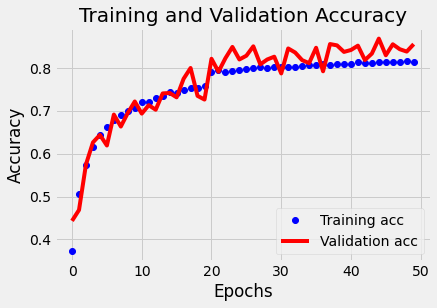

Training Accuracy: 0.8145250082015991
Validation Accuracy: 0.855400025844574


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

#acc = history.history['acc']
#val_acc = history.history['val_acc']
acc = acc_list
val_acc =  val_acc_list

epochs = range(len(acc))

# Plot Training vs. Validation
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Training Accuracy: {acc[-1]}")
print(f"Validation Accuracy: {val_acc[-1]}")

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [21]:
# load json and create model
load_model = False

if load_model:
  json_file = open('model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("model.h5")
  print("Loaded model from disk")

In [7]:
#from keras import optimizers
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale= rescale,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip
)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train_vec, batch_size=batch_size)

# test data
val_datagen = ImageDataGenerator(rescale= rescale)
test_generator = val_datagen.flow(x_test, y_test_vec)

model.compile(
    loss=loss,
    optimizer= optimizers.RMSprop(
        learning_rate= learning_rate),
    metrics = metrics
)

In [29]:
#history = model.fit(train_generator, epochs=40)

In [30]:
# Run the Model
# TRAIN
# epoch start point
epoch_i = 0
epochs_to_run = 10  # number of epochs per round

history = model.fit(train_generator, epochs=epochs_to_run)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Epoch 1/10
1563/1563 [==============================] - 460s 292ms/step - loss: 1.6997 - acc: 0.3900
Epoch 2/10
1563/1563 [==============================] - 459s 293ms/step - loss: 1.3168 - acc: 0.5299
Epoch 3/10
1563/1563 [==============================] - 460s 294ms/step - loss: 1.1482 - acc: 0.5957
Epoch 4/10
1563/1563 [==============================] - 457s 292ms/step - loss: 1.0627 - acc: 0.6302
Epoch 5/10
1563/1563 [==============================] - 457s 292ms/step - loss: 0.9871 - acc: 0.6568
Epoch 6/10
1563/1563 [==============================] - 458s 293ms/step - loss: 0.9433 - acc: 0.6763
Epoch 7/10
1563/1563 [==============================] - 457s 292ms/step - loss: 0.9059 - acc: 0.6883
Epoch 8/10
1563/1563 [==============================] - 455s 291ms/step - loss: 0.8679 - acc: 0.7010
Epoch 9/10
1563/1563 [==============================] - 459s 294ms/step - loss: 0.8422 - acc: 0.7094
Epoch 10/10
1563/1563 [==============================] - 455s 291ms/step - loss: 0.8166 - a

In [31]:
# TRAIN 1
epoch_i = 1
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 0 loaded
Epoch 1/10
1563/1563 [==============================] - 460s 294ms/step - loss: 0.8018 - acc: 0.7266
Epoch 2/10
1563/1563 [==============================] - 459s 293ms/step - loss: 0.7807 - acc: 0.7353
Epoch 3/10
1563/1563 [==============================] - 454s 290ms/step - loss: 0.7672 - acc: 0.7392
Epoch 4/10
1563/1563 [==============================] - 456s 292ms/step - loss: 0.7501 - acc: 0.7451
Epoch 5/10
1563/1563 [==============================] - 452s 289ms/step - loss: 0.7372 - acc: 0.7471
Epoch 6/10
1563/1563 [==============================] - 446s 286ms/step - loss: 0.7293 - acc: 0.7520
Epoch 7/10
1563/1563 [==============================] - 441s 282ms/step - loss: 0.7140 - acc: 0.7565
Epoch 8/10
1563/1563 [==============================] - 442s 283ms/step - loss: 0.6987 - acc: 0.7605
Epoch 9/10
1563/1563 [==============================] - 441s 282ms/step - loss: 0.6982 - acc: 0.7646
Epoch 10/10
1563/1563 [==============================] - 447s 286ms/

In [32]:
# TRAIN 2
epoch_i = 2
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 1 loaded
Epoch 1/10
1563/1563 [==============================] - 451s 288ms/step - loss: 0.6794 - acc: 0.7688
Epoch 2/10
1563/1563 [==============================] - 442s 283ms/step - loss: 0.6769 - acc: 0.7704
Epoch 3/10
1563/1563 [==============================] - 449s 287ms/step - loss: 0.6617 - acc: 0.7751
Epoch 4/10
1563/1563 [==============================] - 452s 289ms/step - loss: 0.6566 - acc: 0.7764
Epoch 5/10
1563/1563 [==============================] - 453s 290ms/step - loss: 0.6554 - acc: 0.7778
Epoch 6/10
1563/1563 [==============================] - 453s 290ms/step - loss: 0.6470 - acc: 0.7810
Epoch 7/10
1563/1563 [==============================] - 453s 290ms/step - loss: 0.6409 - acc: 0.7823
Epoch 8/10
1563/1563 [==============================] - 453s 290ms/step - loss: 0.6353 - acc: 0.7848
Epoch 9/10
1563/1563 [==============================] - 452s 289ms/step - loss: 0.6298 - acc: 0.7856
Epoch 10/10
1563/1563 [==============================] - 449s 288ms/

In [11]:
# TRAIN 3
epoch_i = 3
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 2 loaded
Epoch 1/10
1563/1563 [==============================] - 511s 325ms/step - loss: 0.6232 - acc: 0.7891
Epoch 2/10
1563/1563 [==============================] - 505s 323ms/step - loss: 0.6233 - acc: 0.7874
Epoch 3/10
1563/1563 [==============================] - 502s 321ms/step - loss: 0.6134 - acc: 0.7924
Epoch 4/10
1563/1563 [==============================] - 521s 333ms/step - loss: 0.6065 - acc: 0.7947
Epoch 5/10
1563/1563 [==============================] - 526s 336ms/step - loss: 0.6062 - acc: 0.7958
Epoch 6/10
1563/1563 [==============================] - 520s 332ms/step - loss: 0.6049 - acc: 0.7950
Epoch 7/10
1563/1563 [==============================] - 520s 333ms/step - loss: 0.6021 - acc: 0.7960
Epoch 8/10
1563/1563 [==============================] - 519s 332ms/step - loss: 0.6022 - acc: 0.7972
Epoch 9/10
1563/1563 [==============================] - 524s 335ms/step - loss: 0.5987 - acc: 0.7985
Epoch 10/10
1563/1563 [==============================] - 515s 329ms/

In [12]:
# TRAIN 4
epoch_i = 4
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 3 loaded
Epoch 1/10
1563/1563 [==============================] - 512s 327ms/step - loss: 0.5881 - acc: 0.7999
Epoch 2/10
1563/1563 [==============================] - 518s 331ms/step - loss: 0.5816 - acc: 0.8027
Epoch 3/10
1563/1563 [==============================] - 515s 329ms/step - loss: 0.5848 - acc: 0.8039
Epoch 4/10
1563/1563 [==============================] - 513s 328ms/step - loss: 0.5795 - acc: 0.8039
Epoch 5/10
1563/1563 [==============================] - 509s 326ms/step - loss: 0.5778 - acc: 0.8069
Epoch 6/10
1563/1563 [==============================] - 510s 326ms/step - loss: 0.5749 - acc: 0.8051
Epoch 7/10
1563/1563 [==============================] - 509s 326ms/step - loss: 0.5761 - acc: 0.8058
Epoch 8/10
1563/1563 [==============================] - 517s 331ms/step - loss: 0.5733 - acc: 0.8080
Epoch 9/10
1563/1563 [==============================] - 520s 333ms/step - loss: 0.5687 - acc: 0.8076
Epoch 10/10
1563/1563 [==============================] - 506s 324ms/

In [10]:
# TRAIN 5
epoch_i = 5
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 4 loaded
Epoch 1/10
1563/1563 [==============================] - 490s 312ms/step - loss: 0.5719 - acc: 0.8081
Epoch 2/10
1563/1563 [==============================] - 484s 309ms/step - loss: 0.5631 - acc: 0.8087
Epoch 3/10
1563/1563 [==============================] - 483s 309ms/step - loss: 0.5627 - acc: 0.8087
Epoch 4/10
1563/1563 [==============================] - 484s 310ms/step - loss: 0.5553 - acc: 0.8129
Epoch 5/10
1563/1563 [==============================] - 483s 309ms/step - loss: 0.5587 - acc: 0.8115
Epoch 6/10
1563/1563 [==============================] - 483s 309ms/step - loss: 0.5602 - acc: 0.8108
Epoch 7/10
1563/1563 [==============================] - 485s 310ms/step - loss: 0.5500 - acc: 0.8141
Epoch 8/10
1563/1563 [==============================] - 483s 309ms/step - loss: 0.5582 - acc: 0.8116
Epoch 9/10
1563/1563 [==============================] - 499s 319ms/step - loss: 0.5518 - acc: 0.8124
Epoch 10/10
1563/1563 [==============================] - 498s 318ms/

In [8]:
# TRAIN 6
epoch_i = 6
epochs_to_run = 5  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 5 loaded
Epoch 1/5
1250/1250 [==============================] - 437s 346ms/step - loss: 0.5483 - acc: 0.8152
Epoch 2/5
1250/1250 [==============================] - 425s 340ms/step - loss: 0.5421 - acc: 0.8166
Epoch 3/5
1250/1250 [==============================] - 421s 337ms/step - loss: 0.5461 - acc: 0.8167
Epoch 4/5
1250/1250 [==============================] - 413s 330ms/step - loss: 0.5388 - acc: 0.8189
Epoch 5/5
1250/1250 [==============================] - 413s 331ms/step - loss: 0.5423 - acc: 0.8170
6
Model weights 6 to disk


In [16]:
# TRAIN 7
epoch_i = 7
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 6 loaded
Epoch 1/10
1250/1250 [==============================] - 409s 327ms/step - loss: 0.5472 - acc: 0.8165
Epoch 2/10
1250/1250 [==============================] - 406s 325ms/step - loss: 0.5357 - acc: 0.8203
Epoch 3/10
1250/1250 [==============================] - 424s 339ms/step - loss: 0.5312 - acc: 0.8211
Epoch 4/10
1250/1250 [==============================] - 420s 336ms/step - loss: 0.5352 - acc: 0.8181
Epoch 5/10
1250/1250 [==============================] - 431s 345ms/step - loss: 0.5368 - acc: 0.8159
Epoch 6/10
1250/1250 [==============================] - 426s 341ms/step - loss: 0.5353 - acc: 0.8174
Epoch 7/10
1250/1250 [==============================] - 425s 340ms/step - loss: 0.5298 - acc: 0.8207
Epoch 8/10
1250/1250 [==============================] - 425s 340ms/step - loss: 0.5298 - acc: 0.8197
Epoch 9/10
1250/1250 [==============================] - 426s 341ms/step - loss: 0.5272 - acc: 0.8230
Epoch 10/10
1250/1250 [==============================] - 432s 345ms/

In [18]:
# TRAIN 8
epoch_i = 8
epochs_to_run = 10  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 7 loaded
Epoch 1/10
1250/1250 [==============================] - 442s 354ms/step - loss: 0.5246 - acc: 0.8245
Epoch 2/10
1250/1250 [==============================] - 429s 343ms/step - loss: 0.5225 - acc: 0.8232
Epoch 3/10
1250/1250 [==============================] - 428s 342ms/step - loss: 0.5300 - acc: 0.8244
Epoch 4/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.5232 - acc: 0.8251
Epoch 5/10
1250/1250 [==============================] - 453s 363ms/step - loss: 0.5259 - acc: 0.8250
Epoch 6/10
1250/1250 [==============================] - 442s 353ms/step - loss: 0.5206 - acc: 0.8223
Epoch 7/10
1250/1250 [==============================] - 435s 348ms/step - loss: 0.5198 - acc: 0.8255
Epoch 8/10
1250/1250 [==============================] - 430s 344ms/step - loss: 0.5195 - acc: 0.8256
Epoch 9/10
1250/1250 [==============================] - 428s 342ms/step - loss: 0.5182 - acc: 0.8260
Epoch 10/10
1250/1250 [==============================] - 434s 347ms/

In [19]:
# TRAIN 9
epoch_i = 9
epochs_to_run = 5  # number of epochs per round

epoch_i -= 1

# load model wgts
model.load_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f'Model weights {epoch_i} loaded')

#train model
history = model.fit(train_generator, epochs=epochs_to_run)

# save model wgts to next iteration
epoch_i += 1
print(epoch_i)
model.save_weights(f'{model_wgt_path}/my_checkpoint_tr{epoch_i}')
print(f"Model weights {epoch_i} to disk")

Model weights 8 loaded
Epoch 1/5
1250/1250 [==============================] - 430s 344ms/step - loss: 0.5211 - acc: 0.8269
Epoch 2/5
1250/1250 [==============================] - 425s 340ms/step - loss: 0.5184 - acc: 0.8257
Epoch 3/5
1250/1250 [==============================] - 436s 349ms/step - loss: 0.5171 - acc: 0.8258
Epoch 4/5
1250/1250 [==============================] - 428s 342ms/step - loss: 0.5165 - acc: 0.8258
Epoch 5/5
1250/1250 [==============================] - 429s 343ms/step - loss: 0.5064 - acc: 0.8309
9
Model weights 9 to disk


In [20]:
# Save fully trained model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [21]:

loss_and_acc = model.evaluate(test_generator)
#loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 24s 76ms/step - loss: 0.4729 - acc: 0.8480
loss = 0.47292205691337585
accuracy = 0.8479999899864197
